# Loss Landscapes of Regularized Linear Autoencoders
This is the code used to produce figures 3-8. Run cells sequentially.

### Imports

In [22]:
from keras import backend as K
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.layers import Input, Dense, Dropout
from keras import initializers, regularizers, models, optimizers, callbacks
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.25); sns.set_style("whitegrid");
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
import random

### Util Functions

In [8]:
random.seed(0)
np.random.seed(0)

def display(xlabel="", ylabel="", title="", legend=False, colorbar=False, ticks=True, xscale="linear", yscale="linear", show=True):
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend:
        plt.legend()
    if colorbar:
        plt.colorbar()
    if not ticks:
        plt.tick_params(axis='both', width='0',labelsize='0')
    if show:
        plt.show()
    
def svd(X, k):
    U, S, V = np.linalg.svd(X, full_matrices=False)
    loss = np.sum((X - U[:,:k].dot(np.diag(S[:k])).dot(V[:k,:]))**2)
    return U[:,:k], S[:k], V[:k,:].T, loss

def hyperparameters(learning_rate=1e-3, decay=1e-3, epochs=10, batch_size=32):
    return {
        'lr': learning_rate,
        'dr': decay,
        'ep': epochs,
        'bs': batch_size,
    }

### Autoencoder Model

In [3]:
def regularization(W1, W2, constant, method):
    if method == 1:
        return constant * K.sum(K.square(K.dot(W1,W2)))
    elif method == 2:
        return constant * (K.sum(K.square(W1)) + K.sum(K.square(W2)))
    else:
        return 0

def LAE(m, k, constant=0, method=0, bias=True, stddev=0.05):
    
    encode_layer = Dense(k, activation='linear', use_bias=bias, kernel_initializer=initializers.RandomNormal(stddev=stddev))
    dropout_layer = Dropout(rate=np.sqrt(1.0/(1.0 + constant)))
    decode_layer = Dense(m, activation='linear', use_bias=bias, kernel_initializer=initializers.RandomNormal(stddev=stddev))
    
    X = Input(shape=(m,))
    Z = encode_layer(X)
    Y = decode_layer(Z)
    
    autoencoder = models.Model(X,Y)
    
    W1 = encode_layer.trainable_weights[0]
    W2 = decode_layer.trainable_weights[0]
    autoencoder.add_loss(regularization(W1, W2, constant, method))
    
    
    return autoencoder

### Training

In [4]:
class logger(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_loss = []
        self.weight_difference = []

    def on_batch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        
        parameters = self.model.get_weights()
        if len(parameters) == 4:
            W1, _, W2, _ = parameters
        else:
            W1, W2 = parameters
        self.weight_difference.append(np.sum((W1 - W2.T)**2))

def square_error(x, y):
    return K.sum(K.square(x - y))
        
def train(X, model, hp, callbacks=[], shuffle=True, verbose=0):
    model.compile(optimizer=optimizers.Adam(lr=hp['lr'], decay=hp['dr']), loss=square_error)   
    model.fit(X, X, epochs=hp['ep'], batch_size=hp['bs'], shuffle=shuffle, verbose=verbose, callbacks=callbacks)

## Synthetic Data

### Generate Data

In [5]:
def generate(n, m, sigma):
    Ux, _ = np.linalg.qr(np.random.randn(n,n));   
    Vx, _ = np.linalg.qr(np.random.randn(m,m));  
    Sx = np.zeros((n,m))
    for i, val in enumerate(sigma):
        Sx[i,i] = val
    return Ux.dot(Sx).dot(Vx.T)

In [6]:
n, m  = 20, 20
X = generate(n, m, np.arange(1, m + 1))

### Model Parameters

In [7]:
k = 10
alpha = 10
hp = hyperparameters(learning_rate=5e-2, decay=1e-1, epochs=4000, batch_size=n)

### Transpose Theorem

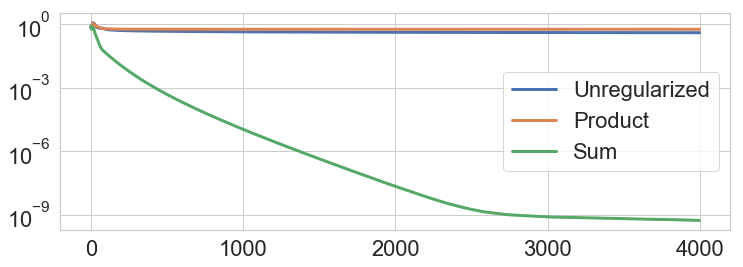

In [19]:
plt.rcParams['figure.figsize'] = [12, 4]
methods = ['Unregularized', 'Product', 'Sum']

for index, method in enumerate(methods):
    
    # train
    autoencoder = LAE(m, k, alpha, index, bias=False)
    log = logger()
    train(X, autoencoder, hp, callbacks=[log], shuffle=False)
    
    # plot
    plt.plot(log.weight_difference, label=method, lw=3)
display(yscale='log', legend=True, show=False)
plt.yticks([1e-0,1e-3,1e-6,1e-9])
plt.xticks([0,1000,2000,3000,4000])
plt.show()

### Relationship between Singular Vectors of X and W (V)

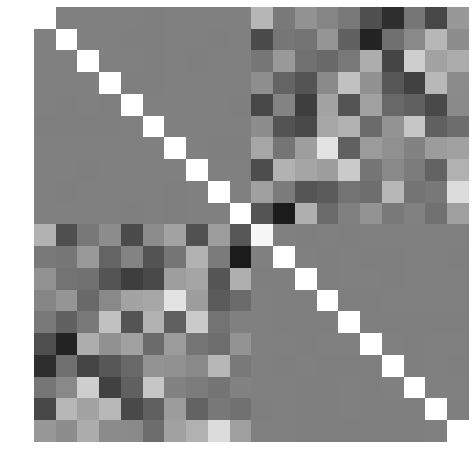

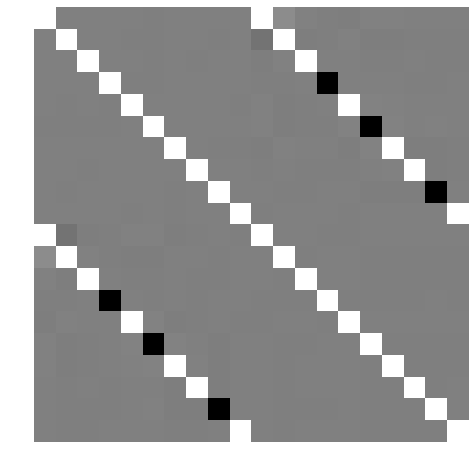

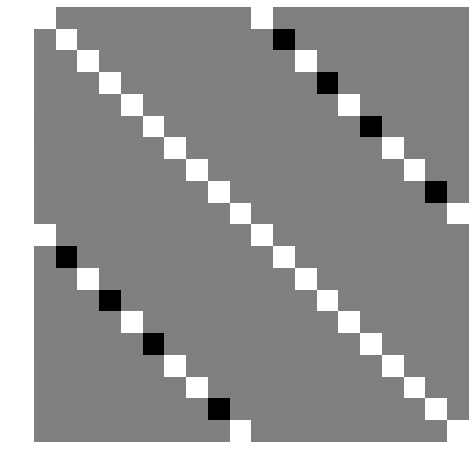

In [95]:
plt.rcParams['figure.figsize'] = [8, 8]
methods = ['No Reg', 'Product Reg', 'Sum Reg']

_, _, VX, _ = svd(X, k)

for index, method in enumerate(methods):
    
    # train
    autoencoder = LAE(m, k, alpha, index, bias=False)
    train(X, autoencoder, hp, shuffle=False)
    W1, W2 = autoencoder.get_weights()
    UW, _, VW, _ = svd(W1 @ W2, k)
    
    # compute vectors
    A = np.concatenate((VX.T, UW.T), axis=0)
    B = np.concatenate((VX, VW), axis=1)
        
    # plot outer product
    plt.imshow(A @ B, cmap='gray')
    plt.clim(-1,1)
    plt.axis('off')
    plt.show()

### Singular Value Shrinkage of W (S)

In [20]:
def shrinkage(alpha, X, k, method):
    if method == 1:
        _, S, _, _ = svd(X, k)
        return 1.0 / (np.ones(k) + alpha / S**2)
    elif method == 2:
        _, S, _, _ = svd(X, k)
        return np.maximum(np.zeros(k), np.ones(k) - alpha / S**2)
    else:
        return np.ones(k)

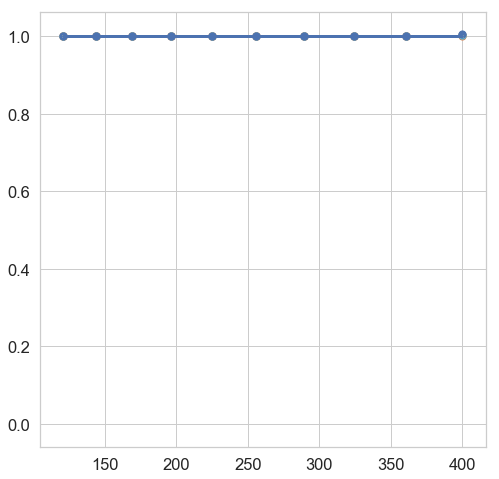

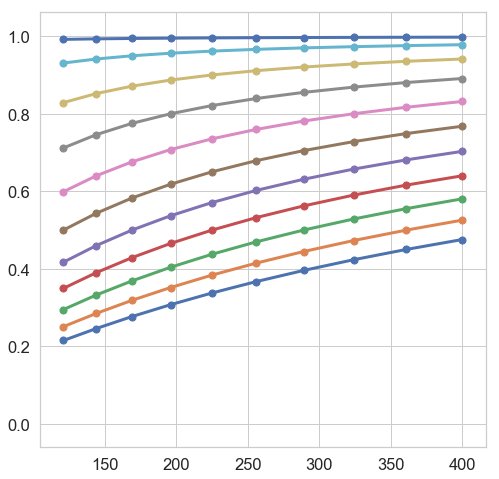

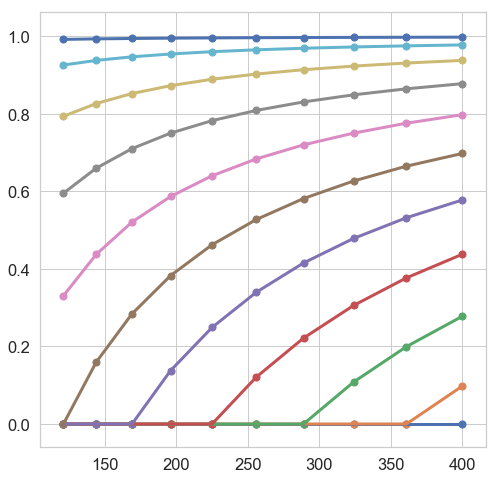

In [24]:
plt.rcParams['figure.figsize'] = [8, 8]
ax = None
methods = ['No Reg', 'Product Reg', 'Sum Reg']

# hyperparameters
alphas = (np.arange(1,22,2)**2)[::-1]

_, SX, _, _ = svd(X, k)

for index, method in enumerate(methods):
    fig = plt.figure()
    ax = plt.subplot(111, sharey=ax)
    for a in alphas:

        # train
        autoencoder = LAE(m, k, a, index, bias=False)
        train(X, autoencoder, hp, shuffle=False)
        W1, W2 = autoencoder.get_weights()
        W = W1 @ W2
        _, SW_empirical, _, _ = svd(W, k)
        SW_theory = shrinkage(a, X, k, index)

        # plot
        plt.scatter(SX**2, SW_empirical, label=str(a), s=50)
        plt.plot(SX**2, SW_theory, linewidth=3)
display()

### Constraints on Singular Vectors of W1 and W2 (G)

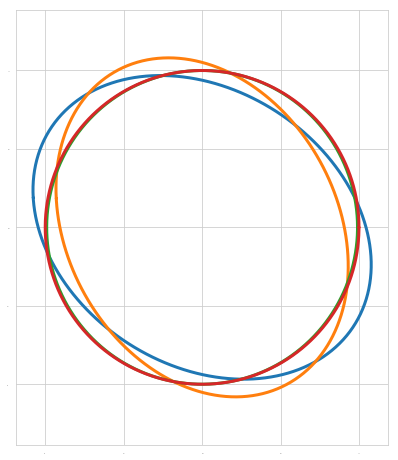

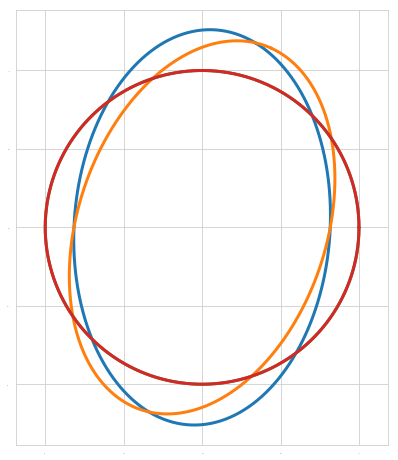

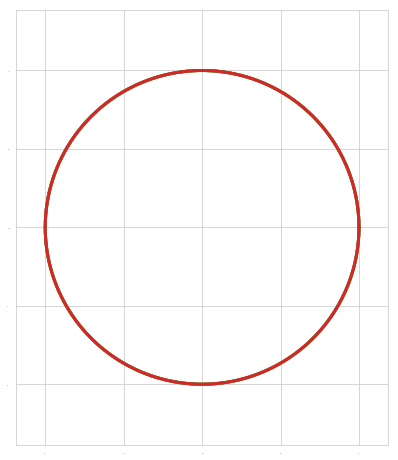

In [25]:
plt.rcParams['figure.figsize'] = [8, 8]
ax = None
methods = ['No Reg', 'Product Reg', 'Sum Reg']

k = 2
_, _, V, _ = svd(X, k)


for index, method in enumerate(methods):
    
    # train
    autoencoder = LAE(m, k, alpha, index, bias=False, stddev=0.2)
    train(X, autoencoder, hp, shuffle=False)
    W1, W2 = autoencoder.get_weights()
    _, S, _, _ = svd(W1 @ W2, k)
    
    # determine G
    G1 = np.diag(S**(-0.5)) @ V.T @ W1
    G2 = W2 @ V @ np.diag(S**(-0.5))
    
    # compute unit circle and transformation
    theta = np.linspace(0, 2 * np.pi, num=500)
    unit = np.stack((np.cos(theta), np.sin(theta)))
    unit1 = G1 @ unit
    unit2 = G2 @ unit
    unit3 = G1 @ G2 @ unit

    # plot transformations
    fig = plt.figure()
    ax = plt.subplot(111, sharex=ax, sharey=ax, aspect='equal')
    plt.plot(unit1[0,:], unit1[1,:], label='AC', linewidth=3)
    plt.plot(unit2[0,:], unit2[1,:], label='BC', linewidth=3)
    plt.plot(unit3[0,:], unit3[1,:], label='ABC', linewidth=3)
    plt.plot(unit[0,:], unit[1,:], label='C', linewidth=3)
    display(ticks=False, show=False)

## MNIST Test

### Get data

In [27]:
(_, _), (X, Y) = mnist.load_data()                                              
n, w, h = X.shape 
m = w * h
X = np.reshape(X,[n, m]).astype('float32') / 255

### Model Parameters

In [43]:
k = 9
alpha = 10
hp = hyperparameters(learning_rate=5e-2, decay=1e-3, epochs=100, batch_size=32)

### Weights

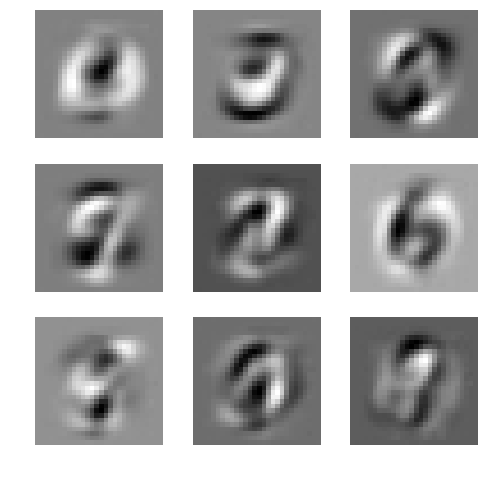

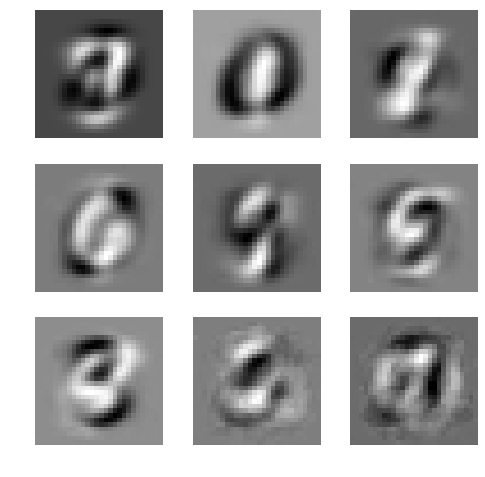

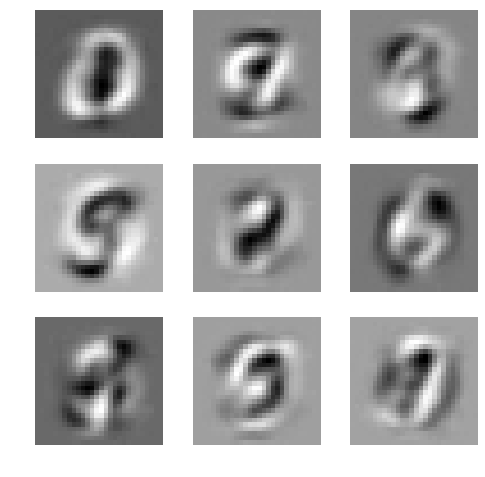

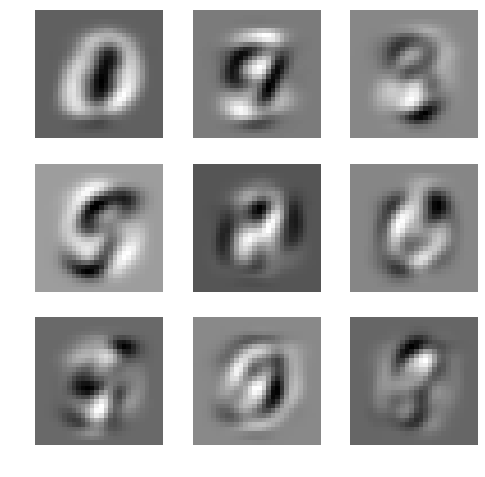

In [44]:
plt.rcParams['figure.figsize'] = [8, 8]
methods = ['No Reg', 'Product Reg', 'Sum Reg', 'PCA']

for index, method in enumerate(methods):
    
    # train
    if method == 'PCA':
        pca = PCA(n_components=k)
        pca = pca.fit(X)
        V = pca.components_.T
        
    else:
        autoencoder = LAE(m, k, alpha, index, bias=True, stddev=1)
        train(X, autoencoder, hp)
        W1, _, W2, _ = autoencoder.get_weights()
        _, S, V, _ = svd(W2, k)
        V = V[:,np.argsort(S)[::-1]]
        
    # plot weights
    V = V.reshape([w, h, k], order='C')
    side = int(np.ceil(np.sqrt(k)))
    for i in range(k):
        plt.subplot(side, side, i + 1)
        plt.imshow(V[:, :, i], cmap='gray')
        plt.axis('off')
    plt.show()

### Embeddings

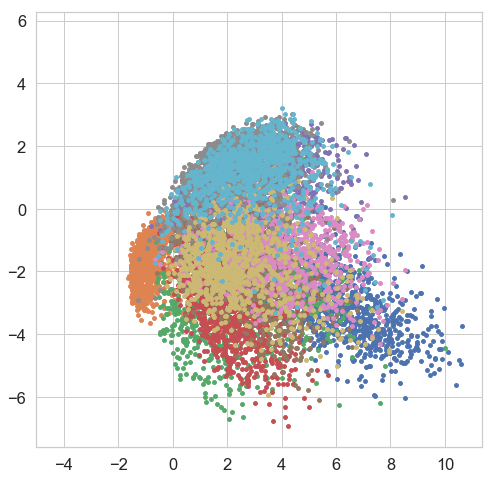

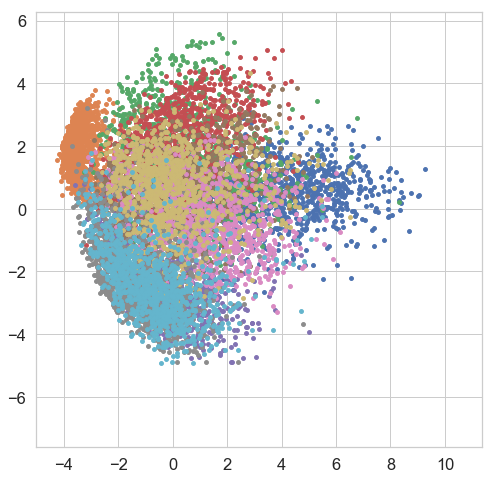

In [41]:
plt.rcParams['figure.figsize'] = [8, 8]
methods = ['Sum Reg', 'PCA']
ax = None

k = 2

for index, method in enumerate(methods):
    
    # train
    if method == 'PCA':
        pca = PCA(n_components=k)
        embedding = pca.fit_transform(X)
    else:
        autoencoder = LAE(m, k, alpha, 2, bias=True)
        train(X, autoencoder, hp)
        W1, _, _, _ = autoencoder.get_weights()
        embedding = X @ W1
    
    # plot embeddings
    fig = plt.figure()
    ax = plt.subplot(111, sharex=ax, sharey=ax)
    for c in np.unique(Y):
        idx = np.where(Y == c)
        plt.scatter(embedding[idx, 0], embedding[idx, 1], label=c, s=15)
    display('', '', '', legend=False, show=False)
plt.show()